In [1]:
from roofline_survey_utils import *

from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
import re

import glob

Autogen version: 0.4.9.1


In [2]:
# let's read in the CSV file

#resultsCSV = 
#
#df = pd.read_csv(resultsCSV, quotechar='\"')
#
## let's clean the responses
#
#df['isBB'] = df['answer'].apply(lambda x: True if x == 'Bandwidth' else False)
#
#df['cleanResponse'] = df['llmResponse'].apply(cleanup_responses)
#
#df['isLLMCorrect'] = df['answer'] == df['cleanResponse']
#
## add some columns for ease-of-calculations
#df['actual'] = df['answer'].apply(lambda x: 1 if x == 'Bandwidth' else 2)
#df['predicted'] = df['cleanResponse'].apply(lambda x: 1 if x == 'Bandwidth' else 2)

In [3]:
#print(df.dtypes)

In [4]:

def cleanup_responses(x):
    #print('input:', x)
    if not (str(x) == '<NA>'):
        matches = re.finditer(r'([bB]andwidth|[cC]ompute)', x, re.MULTILINE)
        matches = [m for m in matches]
        if len(matches) > 1:
            # just take the last match
            print('\tMore than 1 match, taking last one!')
            matches = [matches[-1]]
        else:
            assert len(matches) == 1
        for match in matches:
            m = match.group()
            return m.title()

    print(f'returning NA for [{x}]')
    assert False, "this should never be reached!"
    return 'NA'

In [5]:
def calc_metrics_of_df(df):
    accuracy = accuracy_score(df['actual'], df['predicted'])
    f1 = f1_score(df['actual'], df['predicted'], average='macro')
    mcc = matthews_corrcoef(df['actual'], df['predicted'])
    return (accuracy, f1, mcc)

In [6]:
def read_results_csv(csvFile):
    useCOT = False
    hasLogProbs = False
    if 'COT-' in csvFile:
        useCOT = True
    else:
        assert 'simple-' in csvFile, "Don't recognize input CSV file"

    if '-withLogProbs-' in csvFile:
        hasLogProbs = True

    regex = r"(?<=-inference-results-).*(?=.csv)"

    matches = re.finditer(regex, csvFile, re.MULTILINE)

    matches = [match for match in matches]
    assert len(matches) == 1

    modelName =  matches[0].group()
    #modelName = csvFile[len(f"{'COT' if useCOT else 'simple'}-{'withLogProbs' if hasLogProbs else ''}-inference-results-"):-4]

    df = pd.read_csv(csvFile, quotechar='\"')
    
    # let's just drop the failed cases for now
    df = df.dropna(subset=['llmResponse'])

    # do some response cleanup for returned strings that have more than 1 token
    df['llmResponse'] = df['llmResponse'].apply(cleanup_responses)
    # check if the LLM produced the correct answer
    df['isLLMCorrect'] = df.apply(lambda x: x['answer'] == x['llmResponse'], axis=1)
    
    return (df, modelName, useCOT, hasLogProbs)

In [7]:
# let's make a heatmap for each metric
# x axis = (temp, topp)
# y axis = (2 shot, 4 shot, 8 shot)
# subplot = (accuracy, F1, MCC)


def make_metric_heatmaps(df, title=''):

    fig, axs = plt.subplots(1,3, figsize=(20,5))

    keepCols = ['temp', 'topp', 'numExamples', 'actual', 'predicted']

    accDF = df.groupby(['temp', 'topp', 'numExamples'])[keepCols].apply(lambda x: calc_metrics_of_df(x)[0]).reset_index(name='Accuracy')

    # Group by temp, topp and numExamples and calculate mean accuracy
    grouped_df = accDF.groupby(['temp', 'topp', 'numExamples']).mean()['Accuracy'].reset_index()

    # Pivot the dataframe for heatmap
    pivot_df = grouped_df.pivot(columns='numExamples', index=['temp', 'topp'], values='Accuracy')

    # Plot heatmap
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', ax=axs[0])
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel('numExamples')
    axs[0].set_ylabel('(temp, topp)')



    f1DF = df.groupby(['temp', 'topp', 'numExamples'])[keepCols].apply(lambda x: calc_metrics_of_df(x)[1]).reset_index(name='F1 Score (macro)')

    # Group by temp, topp and numExamples and calculate mean accuracy
    grouped_df = f1DF.groupby(['temp', 'topp', 'numExamples']).mean()['F1 Score (macro)'].reset_index()

    # Pivot the dataframe for heatmap
    pivot_df = grouped_df.pivot(columns='numExamples', index=['temp', 'topp'], values='F1 Score (macro)')

    # Plot heatmap
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', ax=axs[1])
    axs[1].set_title('F1 Score (macro)')
    axs[1].set_xlabel('Number of Few-shot Examples')
    axs[1].set_ylabel('(Temperature, Top P)')



    mccDF = df.groupby(['temp', 'topp', 'numExamples'])[keepCols].apply(lambda x: calc_metrics_of_df(x)[2]).reset_index(name='MCC')

    # Group by temp, topp and numExamples and calculate mean accuracy
    grouped_df = mccDF.groupby(['temp', 'topp', 'numExamples']).mean()['MCC'].reset_index()

    # Pivot the dataframe for heatmap
    pivot_df = grouped_df.pivot(columns='numExamples', index=['temp', 'topp'], values='MCC')

    # Plot heatmap
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', ax=axs[2])
    axs[2].set_title('MCC')
    axs[2].set_xlabel('Number of Few-shot Examples')
    axs[2].set_ylabel('(Temperature, Top P)')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()
    

    return





In [8]:

def calculate_metrics(csvFiles):

    dfStats = pd.DataFrame()

    # each CSV file will get it's own row in the stats table
    for csvName in csvFiles:
        print('Calculating metrics for ', csvName)
        csvDF, modelName, useCOT, hasLogProbs= read_results_csv(csvName)
        print('Read CSV complete for model:', modelName)

        print(csvDF.head())

        summDict = {}
        summDict['Model Name'] = [modelName]
        summDict['Uses COT'] = [useCOT]
        summDict['Has Log Probs?'] = [hasLogProbs]
        summDict['Number of Samples'] = csvDF.shape[0]


        # add some columns for ease-of-calculations
        csvDF['actual'] = csvDF['answer'].apply(lambda x: 1 if x == 'Bandwidth' else 2)
        csvDF['predicted'] = csvDF['llmResponse'].apply(lambda x: 1 if x == 'Bandwidth' else 2)

        print(f'Plotting for CSV File: {modelName}', csvName)
        make_metric_heatmaps(csvDF, f"{modelName} -- {'COT prompts' if useCOT else 'NO COT prompts'}")

        exampleCounts = list(csvDF['numExamples'].unique())

        for numExamples in exampleCounts:
            # get the samples that have this example count
            subDF = csvDF[csvDF['numExamples'] == numExamples].reset_index(drop=True)
            subMetrics = calc_metrics_of_df(subDF)
            summDict[f'{numExamples}-shot (ACC, F1, MCC)'] = f"({round(100.0*subMetrics[0],2)}, {round(100.0*subMetrics[1],2)}, {round(100.0*subMetrics[2],2)})"


        jointMetrics = calc_metrics_of_df(csvDF)

        summDict['Joint Acc'] = round(100.0*jointMetrics[0],2)
        summDict['Joint F1'] = round(100.0*jointMetrics[1],2)
        summDict['Joint MCC'] = round(100.0*jointMetrics[2],2)

        summDF = pd.DataFrame.from_dict(summDict)
        dfStats = pd.concat([dfStats, summDF], ignore_index=True)


    return dfStats



Calculating metrics for  ./simple-withLogProbs-inference-results-gpt-4o-mini.csv
Read CSV complete for model: gpt-4o-mini
   topp  temp                                        chatHistory  trial  \
0   0.2   0.1  {"messages": [{"role": "system", "content": "Y...      0   
1   0.5   0.1  {"messages": [{"role": "system", "content": "Y...      0   
2   0.9   0.1  {"messages": [{"role": "system", "content": "Y...      0   
3   0.2   0.5  {"messages": [{"role": "system", "content": "Y...      0   
4   0.5   0.5  {"messages": [{"role": "system", "content": "Y...      0   

      answer  useCOT  numExamples llmResponse  llmThought  \
0  Bandwidth   False            2   Bandwidth         NaN   
1  Bandwidth   False            2   Bandwidth         NaN   
2  Bandwidth   False            2   Bandwidth         NaN   
3  Bandwidth   False            2   Bandwidth         NaN   
4  Bandwidth   False            2   Bandwidth         NaN   

                                            logprobs  isLLMC

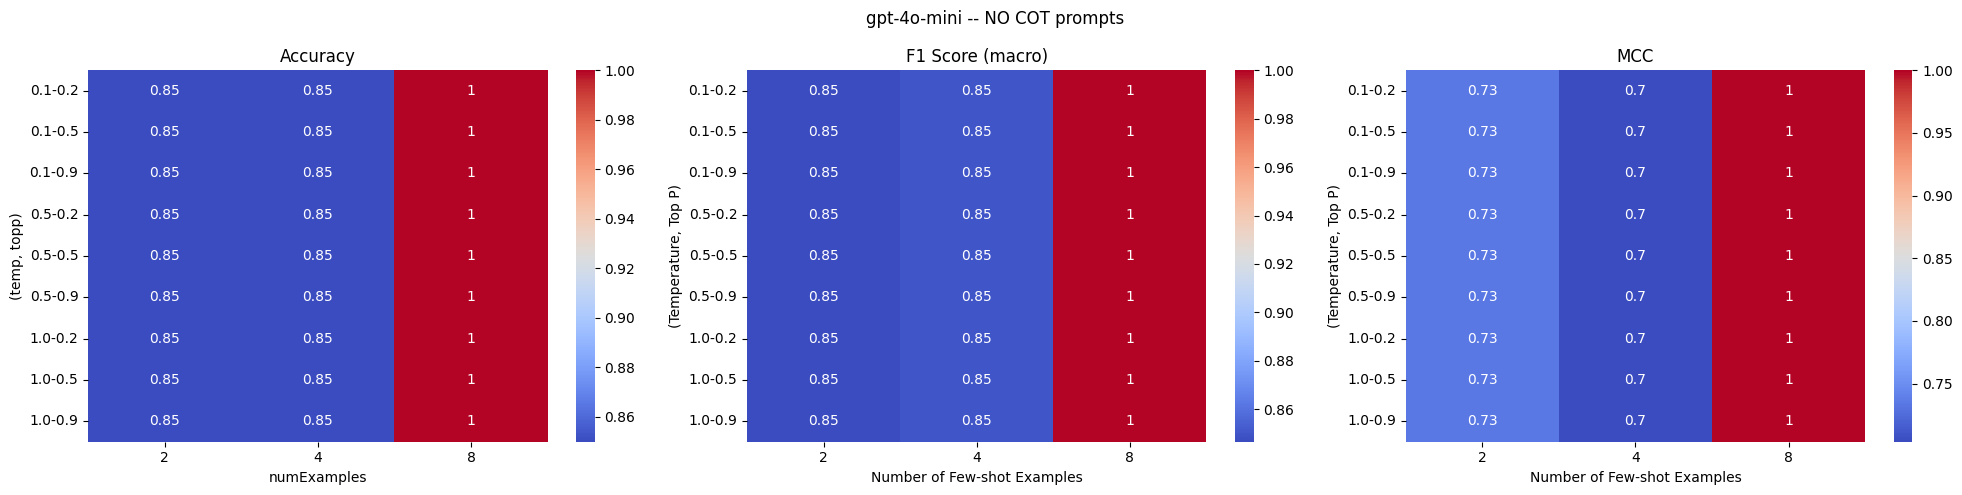

Calculating metrics for  ./COT-withLogProbs-inference-results-gpt-4o-mini.csv
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last on

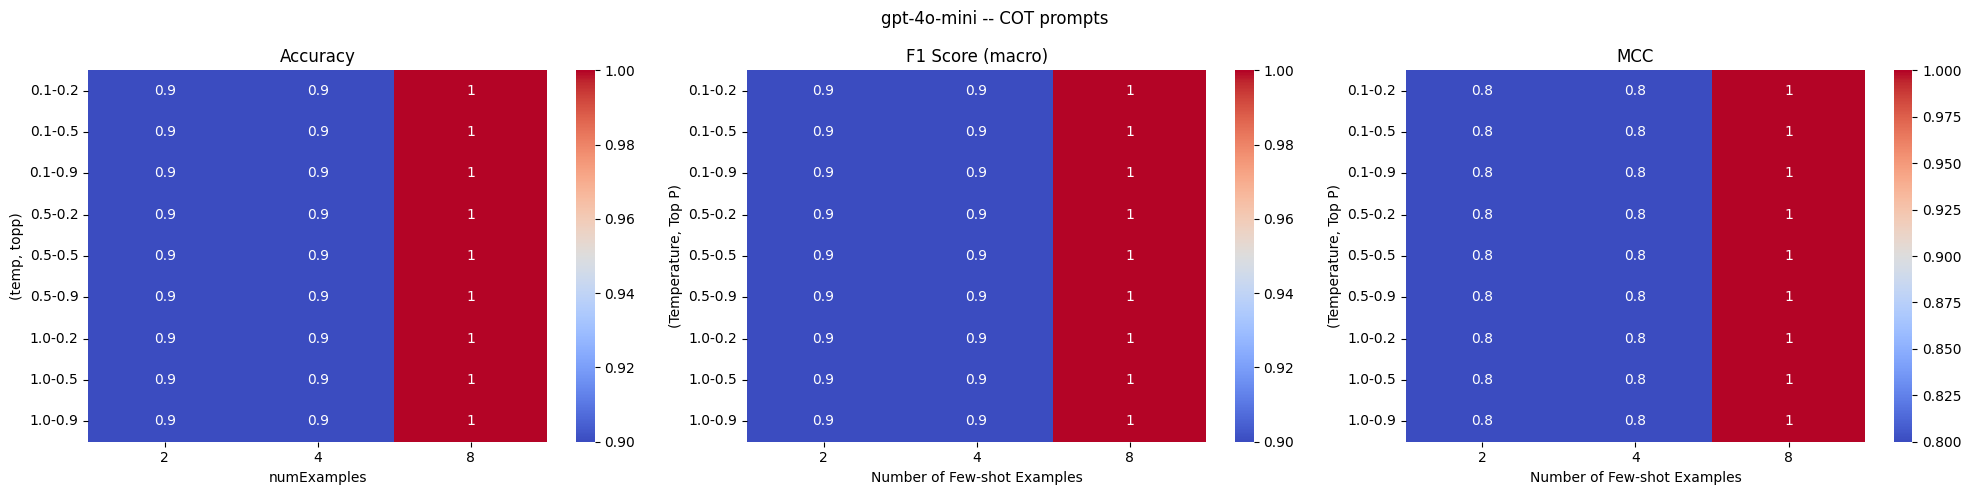

Calculating metrics for  ./simple-withLogProbs-inference-results-gemini-pro-1.5.csv
Read CSV complete for model: gemini-pro-1.5
   topp  temp                                        chatHistory  trial  \
0   0.1   0.1  {"messages": [{"role": "system", "content": "Y...      0   
1   0.8   0.1  {"messages": [{"role": "system", "content": "Y...      0   
2   0.1   0.8  {"messages": [{"role": "system", "content": "Y...      0   
3   0.8   0.8  {"messages": [{"role": "system", "content": "Y...      0   
4   0.1   0.1  {"messages": [{"role": "system", "content": "Y...      0   

      answer  useCOT  numExamples llmResponse  llmThought  logprobs  \
0  Bandwidth   False            2   Bandwidth         NaN       NaN   
1  Bandwidth   False            2   Bandwidth         NaN       NaN   
2  Bandwidth   False            2   Bandwidth         NaN       NaN   
3  Bandwidth   False            2   Bandwidth         NaN       NaN   
4    Compute   False            2     Compute         NaN       Na

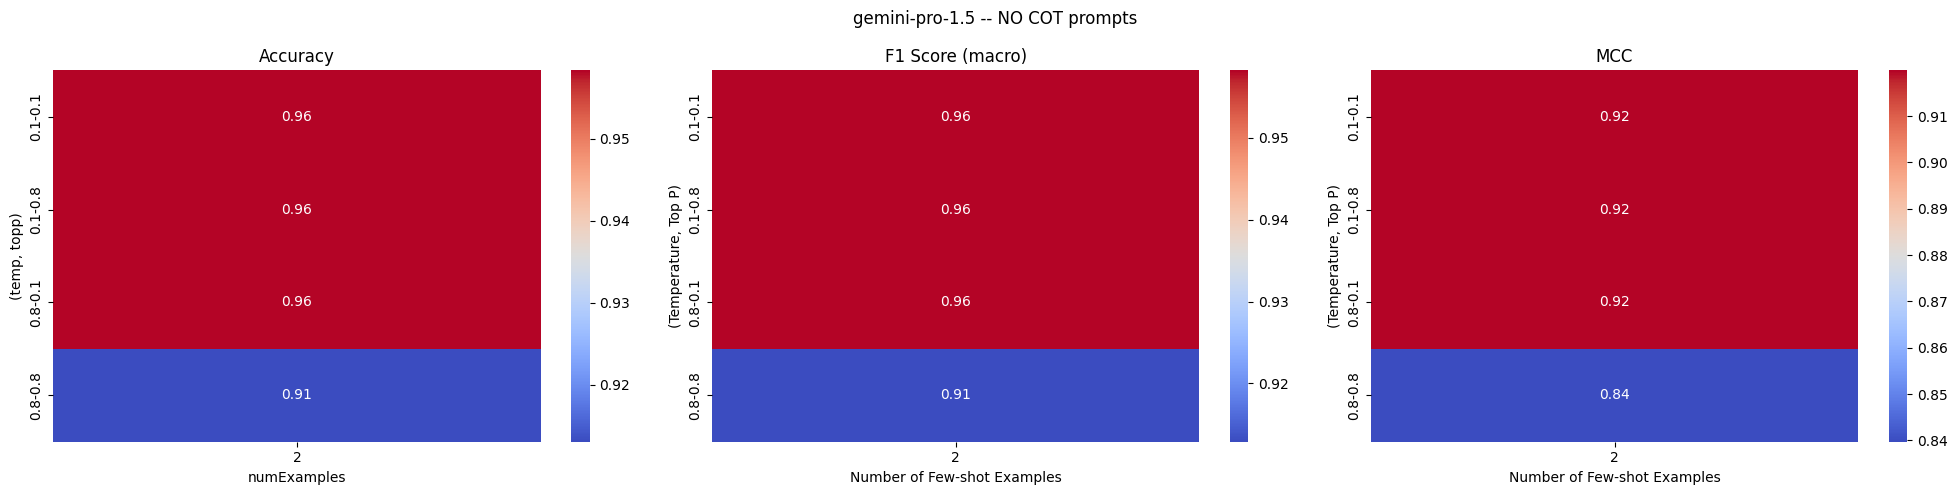

Calculating metrics for  ./COT-inference-results-deepseek-r1-distill-qwen-32b.csv
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking las

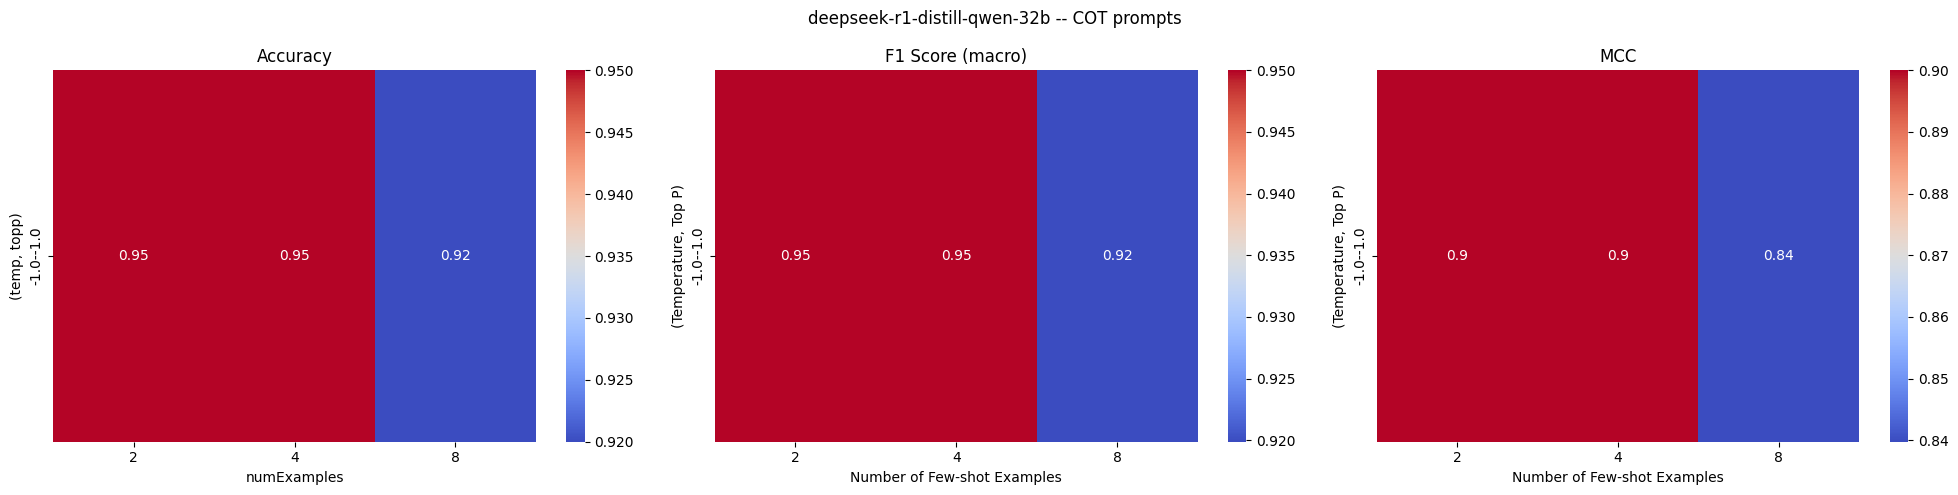

Calculating metrics for  ./COT-withLogProbs-inference-results-gemini-pro-1.5.csv
Read CSV complete for model: gemini-pro-1.5
   topp  temp                                        chatHistory  trial  \
0   0.1   0.1  {"messages": [{"role": "system", "content": "Y...      0   
1   0.8   0.1  {"messages": [{"role": "system", "content": "Y...      0   
2   0.1   0.8  {"messages": [{"role": "system", "content": "Y...      0   
3   0.8   0.8  {"messages": [{"role": "system", "content": "Y...      0   
4   0.1   0.1  {"messages": [{"role": "system", "content": "Y...      0   

      answer  useCOT  numExamples llmResponse  llmThought  logprobs  \
0  Bandwidth    True            2   Bandwidth         NaN       NaN   
1  Bandwidth    True            2   Bandwidth         NaN       NaN   
2  Bandwidth    True            2   Bandwidth         NaN       NaN   
3  Bandwidth    True            2   Bandwidth         NaN       NaN   
4    Compute    True            2     Compute         NaN       NaN  

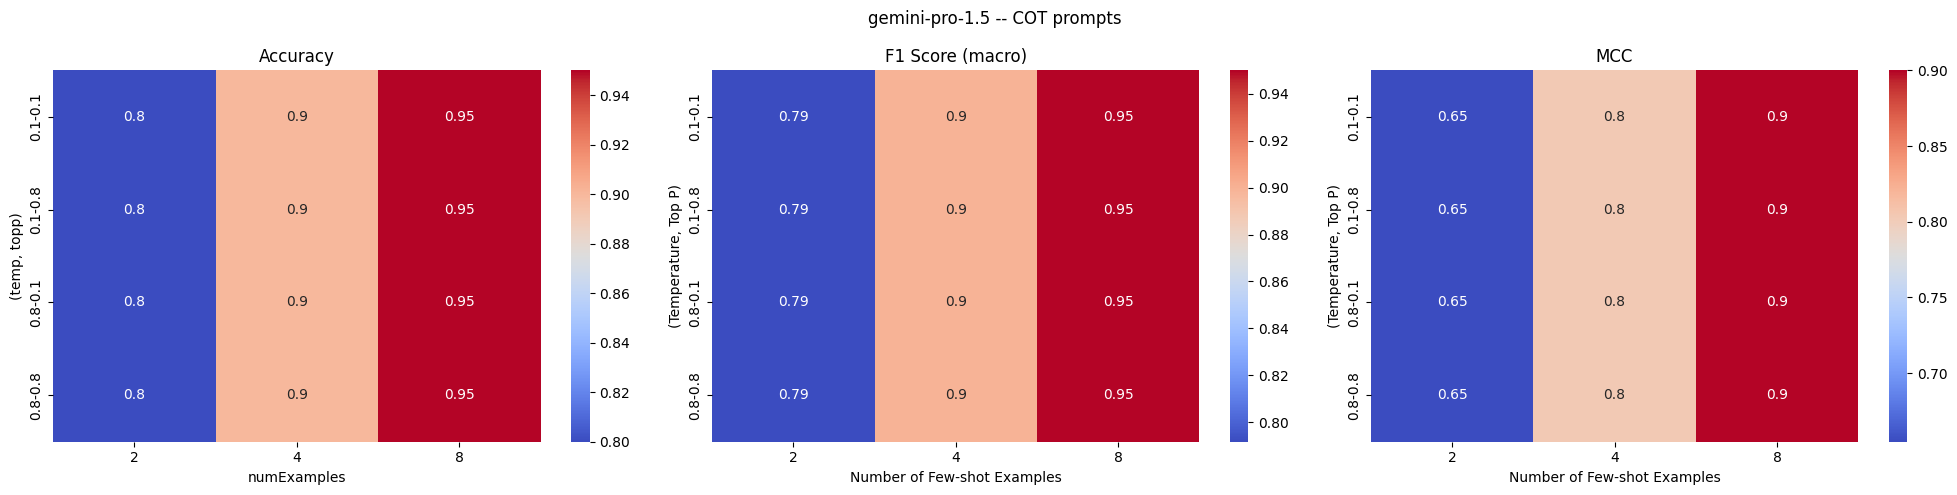

Calculating metrics for  ./simple-inference-results-deepseek-r1-distill-qwen-32b.csv
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
	More than 1 match, taking last one!
Read CSV complete for model: deepseek-r1-distill-qwen-32b
   topp  temp                                        chatHistory  trial  \
0  -1.0  -1.0  {"messages": [{"role": "system", "content": "Y...      0   
1  -1.0  -1.0  {"messages": [{"role": "system", "content": "Y...      0   
2  -1.0  -1.0  {"messages": [{"role": "system", "content": "Y...      1   
3 

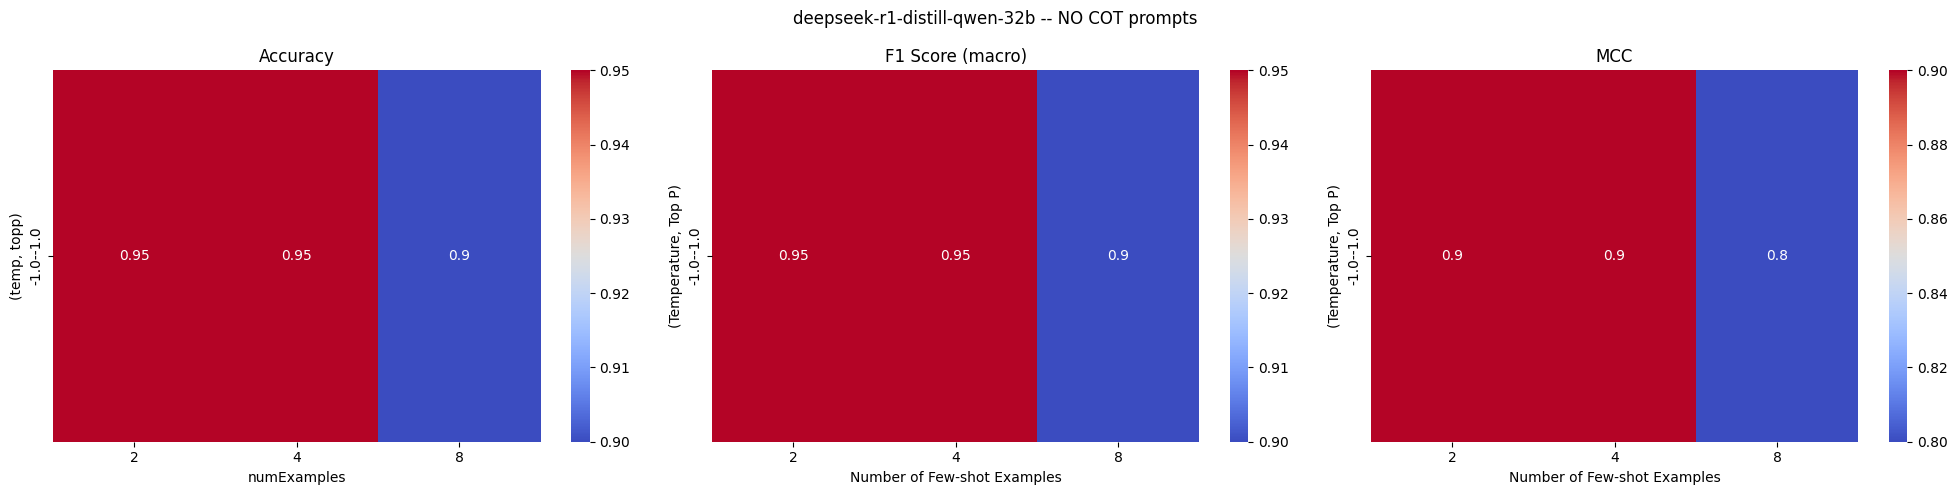

                     Model Name  Uses COT  Has Log Probs?  Number of Samples  \
0                   gpt-4o-mini     False            True                378   
1                   gpt-4o-mini      True            True                378   
2                gemini-pro-1.5     False            True                 95   
3  deepseek-r1-distill-qwen-32b      True           False                105   
4                gemini-pro-1.5      True            True                480   
5  deepseek-r1-distill-qwen-32b     False           False                100   

   2-shot (ACC, F1, MCC) 4-shot (ACC, F1, MCC)  8-shot (ACC, F1, MCC)  \
0   (85.0, 84.65, 73.38)  (85.0, 84.96, 70.35)  (100.0, 100.0, 100.0)   
1     (90.0, 90.0, 80.0)    (90.0, 90.0, 80.0)  (100.0, 100.0, 100.0)   
2  (94.74, 94.73, 89.98)                   NaN                    NaN   
3     (95.0, 95.0, 90.0)    (95.0, 95.0, 90.0)   (92.0, 91.99, 83.97)   
4   (80.0, 79.17, 65.47)   (90.0, 89.97, 80.4)     (95.0, 95.0, 90.0)   
5

In [9]:

csvFiles = list(glob.glob('./*.csv'))

stats = calculate_metrics(csvFiles)

print(stats)